# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

Martin & Onno - 2022

## <a id=top></a>Notebook contents

1. [Observation types](#Obs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)
4. [Precipitation data](#precipitation)
5. [Reference evaporation types](#EvapRef)
6. [Spatial interpolation of evaporation](#EvapInterp)

In [1]:
import hydropandas as hpd
from hydropandas.io import knmi
from IPython.display import display

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator

import logging
import time

%load_ext autoreload
%autoreload 2

In [2]:
hpd.util.get_color_logger("INFO")


<RootLogger root (INFO)>

## [Observation types](#top)<a id=Obs></a>

The hydropandas package has a function to read all kinds of KNMI observations. These are stored in an `Obs` object. There are three types of observations you can obtain from the KNMI:
- `EvaporationObs`, for evaporation time series
- `PrecipitationObs`, for precipitation time series
- `MeteoObs`, for all the other meteorological time series

With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable EV24from 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi EV24 data from station 344-ROTTERDAM between 2022-01-01 00:00:00 and None


,EV24
YYYYMMDD,
2022-01-01 01:00:00,0.0003
2022-01-02 01:00:00,0.0003
2022-01-03 01:00:00,0.0002
2022-01-04 01:00:00,0.0002
2022-01-05 01:00:00,0.0001


<AxesSubplot:xlabel='YYYYMMDD'>

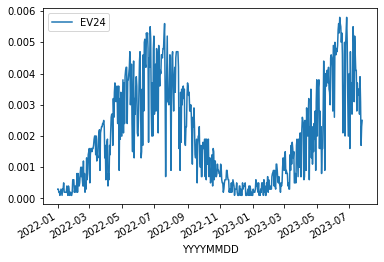

In [3]:
o = hpd.EvaporationObs.from_knmi(stn=344, start="2022")
display(o.head())
o.plot()


INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable RHfrom 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi RH data from station 344-ROTTERDAM between 2022-01-01 00:00:00 and None


,RH
YYYYMMDD,
2022-01-01 01:00:00,0.0000
2022-01-02 01:00:00,0.0002
2022-01-03 01:00:00,0.0064
2022-01-04 01:00:00,0.0000
2022-01-05 01:00:00,0.0008


<AxesSubplot:xlabel='YYYYMMDD'>

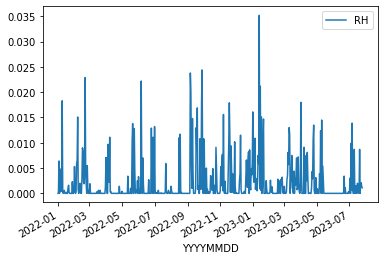

In [4]:
o = hpd.PrecipitationObs.from_knmi(stn=344, start="2022")
display(o.head())
o.plot()


**attributes**

A `MeteoObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coordinate in m RD
* `y`: y-coordinate in m RD
* `station`: station number
* `unit`: measurement unit
* `meta`: dictionary with other metadata

In [5]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print(f"unit", o.unit)
print("metadata:")
for key, item in o.meta.items():
    print(f"    {key}: {item}")


name: RH_ROTTERDAM
x,y: (90598.0, 442813.0)
station: 344
unit 
metadata:
    LON_east: 4.447
    LAT_north: 51.962
    ALT_m: -4.3
    NAME: Rotterdam
    RH: Etmaalsom van de neerslag (in m) (0 voor <0.05mm) / Daily precipitation amount (in m) (0 for <0.05mm)


## [Get KNMI data](#top)<a id=reading></a>

There are 2 main method to obtain meteorological data:

1. `from_knmi`
2. `from_knmi_nearest_xy`

Below you can see how they can be called to obtain the precipitation data. Notice that they return the same data because station 344 is nearest to the given xy coordinates.

In [6]:
o1 = hpd.PrecipitationObs.from_knmi(stn=344)
o2 = hpd.PrecipitationObs.from_knmi(xy=(90600, 442800))
o1.equals(o2)


INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable RHfrom None to None
INFO:hydropandas.io.knmi:download knmi RH data from station 344-ROTTERDAM between None and None
INFO:hydropandas.io.knmi:get KNMI data from station nearest to coordinates (90600, 442800) and meteovariable RH
INFO:hydropandas.io.knmi:download knmi RH data from station 344-ROTTERDAM between None and None


True

**read options**

The `MeteoObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
***

The 3 examples below give a brief summary of these options

INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable TGfrom 1960-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi TG data from station 344-ROTTERDAM between 1960-01-01 00:00:00 and None


<AxesSubplot:xlabel='YYYYMMDD'>

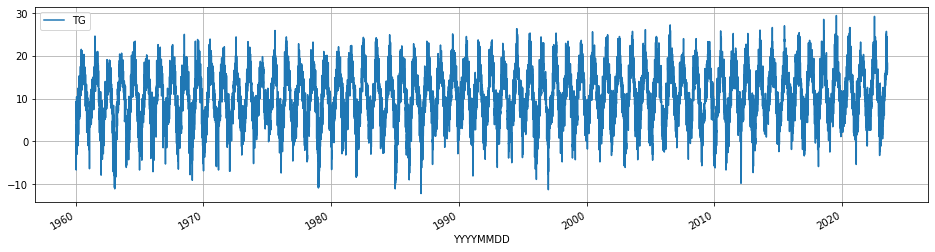

In [7]:
# example 1 get daily average temperature (TG) from 1900 till now
o_t = hpd.MeteoObs.from_knmi("TG", stn=344, start="1960")
o_t.plot(figsize=(16, 4), grid=True)


INFO:hydropandas.io.knmi:get KNMI data from station 892 and meteo variable RDfrom 1972-01-01 00:00:00 to 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:download knmi RD data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:get KNMI data from station 892 and meteo variable RDfrom 1972-01-01 00:00:00 to 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:changing end_date to 2023-01-01
INFO:hydropandas.io.knmi:download knmi RD data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:station 892 has no measurements before 1993-11-01 09:00:00
INFO:hydropandas.io.knmi:station 892 has 7975 missing measurements
INFO:hydropandas.io.knmi:trying to fill 7975 measurements with station [910]
INFO:hydropandas.io.knmi:download knmi RD data from station 910-AMMERZODEN between 1972-01-01 00:00:00 and 2023-01-01 00:00:00


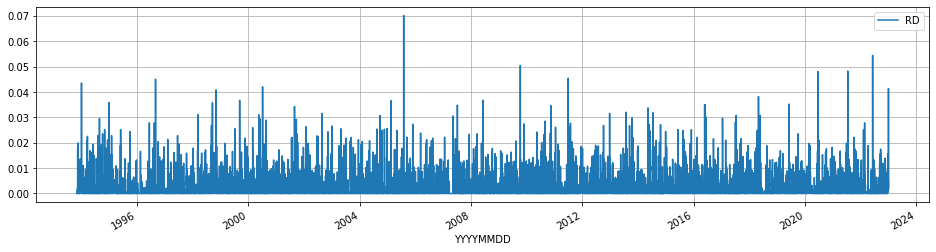

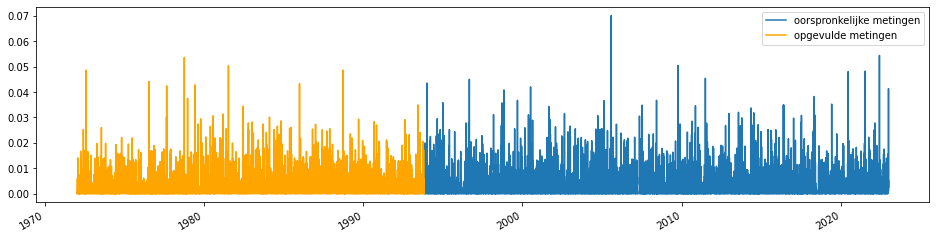

In [8]:
# example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = hpd.PrecipitationObs.from_knmi(
    "RD", stn=892, start="1972", end="2023", fill_missing_obs=False
)
o_rd.plot(figsize=(16, 4), grid=True)

o_rd_filled = hpd.PrecipitationObs.from_knmi(
    "RD", stn=892, start="1972", end="2023", fill_missing_obs=True
)

fig, ax = plt.subplots(figsize=(16, 4))
o_rd_filled.loc[o_rd_filled["station"] == "892", "RD"].plot(
    ax=ax, grid=True, label="oorspronkelijke metingen"
)
o_rd_filled.loc[o_rd_filled["station"] != "892", "RD"].plot(
    ax=ax, color="orange", label="opgevulde metingen"
)

ax.legend()


In [9]:
# see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())


,RD
YYYYMMDD,
1993-11-01 09:00:00,0.0000
1993-11-02 09:00:00,0.0000
1993-11-03 09:00:00,0.0005
1993-11-04 09:00:00,0.0000
1993-11-05 09:00:00,0.0000


,RD,station
1972-01-01 09:00:00,0.0000,910
1972-01-02 09:00:00,0.0000,910
1972-01-03 09:00:00,0.0000,910
1972-01-04 09:00:00,0.0000,910
1972-01-05 09:00:00,0.0004,910


In [10]:
# example 3 get evaporation
logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)

o_ev = hpd.EvaporationObs.from_knmi(
    stn=344, start="1972", end="2023", fill_missing_obs=True
)
o_ev


INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable EV24from 1972-01-01 00:00:00 to 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 344-ROTTERDAM between 1972-01-01 00:00:00 and 2023-01-01 00:00:00


INFO:hydropandas.io.knmi:station 344 has no measurements before 1987-09-12 01:00:00
INFO:hydropandas.io.knmi:station 344 has 5809 missing measurements
INFO:hydropandas.io.knmi:trying to fill 5809 measurements with station [215]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 215-VOORSCHOTEN between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:trying to fill 5809 measurements with station [210]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 210-VALKENBURG between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:trying to fill 5563 measurements with station [330]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.knmi:trying to fill 5563 measurements with station [348]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 348-CABAUW between 1972-01-01 00:00:00 and 2023-01-01 00:00:00
INFO:hydropandas.io.kn

,EV24,station
1972-01-01 01:00:00,0.0002,260
1972-01-02 01:00:00,0.0002,260
1972-01-03 01:00:00,0.0002,260
1972-01-04 01:00:00,0.0000,260
1972-01-05 01:00:00,0.0000,260
...,...,...
2022-12-28 01:00:00,0.0003,344
2022-12-29 01:00:00,0.0001,344
2022-12-30 01:00:00,0.0002,344
2022-12-31 01:00:00,0.0001,344


## [Get ObsCollections](#top)<a id=readingOC></a>

It is also possible to read multiple `Observation` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [11]:
oc = hpd.read_knmi(stns=[344, 260], meteo_vars=["RH", "EV24"])
oc


INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable RHfrom None to None


INFO:hydropandas.io.knmi:download knmi RH data from station 344-ROTTERDAM between None and None
INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable RHfrom None to None
INFO:hydropandas.io.knmi:download knmi RH data from station 260-DE-BILT between None and None
INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable EV24from None to None
INFO:hydropandas.io.knmi:download knmi EV24 data from station 344-ROTTERDAM between None and None
INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable EV24from None to None
INFO:hydropandas.io.knmi:download knmi EV24 data from station 260-DE-BILT between None and None


,x,y,filename,source,unit,station,meteo_var,obs
name,,,,,,,,
RH_ROTTERDAM,90598.000000,442813.000000,,KNMI,,344,RH,PrecipitationObs RH_ROTTERDAM -----metadata---...
RH_DE-BILT,141002.996557,456772.017696,,KNMI,,260,RH,PrecipitationObs RH_DE-BILT -----metadata-----...
EV24_ROTTERDAM,90598.000000,442813.000000,,KNMI,,344,EV24,EvaporationObs EV24_ROTTERDAM -----metadata---...
EV24_DE-BILT,141002.996557,456772.017696,,KNMI,,260,EV24,EvaporationObs EV24_DE-BILT -----metadata-----...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coordinates (RD_new), the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [12]:
location = pd.DataFrame(index=["Rotterdam"], data={"x": 77500, "y": 399500})
hpd.read_knmi(locations=location, meteo_vars=["RH"])


INFO:hydropandas.io.knmi:get KNMI data from station 340 and meteo variable RHfrom None to None
INFO:hydropandas.io.knmi:download knmi RH data from station 340-WOENSDRECHT between None and None


,x,y,filename,source,unit,station,meteo_var,obs
name,,,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,KNMI,,340,RH,PrecipitationObs RH_WOENSDRECHT -----metadata-...


In [13]:
hpd.read_knmi(xy=((77500, 399500),), meteo_vars=["RH"])


INFO:hydropandas.io.knmi:get KNMI data from station 340 and meteo variable RHfrom None to None
INFO:hydropandas.io.knmi:download knmi RH data from station 340-WOENSDRECHT between None and None


,x,y,filename,source,unit,station,meteo_var,obs
name,,,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,KNMI,,340,RH,PrecipitationObs RH_WOENSDRECHT -----metadata-...


## [Precipitation](#top)<a id=precipitation></a>

The KNMI database has three different precipitation products:
1. Daily data from a meteorological station
2. Daily data from a neerslag (precipitation) station
3. Hourly data from a meteorological station

All three products can be obtained using the `from_knmi` method. Product 1 and 2 can also be accessed without the api.

If you want to access the data from a neerslag (precipitation) station you should add `stn_type='precipitation'` to the `PrecipitationObs.from_knmi()` method. 

In [14]:
# daily meteo station
precip1 = hpd.PrecipitationObs.from_knmi(stn=260, start="2010-1-1", end="2010-1-10")


INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable RHfrom 2010-01-01 00:00:00 to 2010-01-10 00:00:00
INFO:hydropandas.io.knmi:download knmi RH data from station 260-DE-BILT between 2010-01-01 00:00:00 and 2010-01-10 00:00:00


In [15]:
# daily neerslag station
precip2 = hpd.PrecipitationObs.from_knmi(
    meteo_var="RD", stn=550, start="2010-1-1", end="2010-1-10"
)


INFO:hydropandas.io.knmi:get KNMI data from station 550 and meteo variable RDfrom 2010-01-01 00:00:00 to 2010-01-10 00:00:00
INFO:hydropandas.io.knmi:download knmi RD data from station 550-DE-BILT between 2010-01-01 00:00:00 and 2010-01-10 00:00:00


In [16]:
# hourly meteo station (only works with api)
precip3 = hpd.PrecipitationObs.from_knmi(
    stn=260,
    start="2010-1-1",
    end="2010-1-10",
    interval="hourly",
)


INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable RHfrom 2010-01-01 00:00:00 to 2010-01-10 00:00:00
INFO:hydropandas.io.knmi:download knmi RH data from station 260-DE-BILT between 2010-01-01 00:00:00 and 2010-01-10 00:00:00


In [17]:
# daily meteo station without api
precip4 = hpd.PrecipitationObs.from_knmi(
    stn=260,
    start="2010-1-1",
    end="2010-1-10",
    use_api=False,
)


INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable RHfrom 2010-01-01 00:00:00 to 2010-01-10 00:00:00


INFO:hydropandas.io.knmi:download knmi RH data from station 260-DE-BILT between 2010-01-01 00:00:00 and 2010-01-10 00:00:00


In [18]:
# daily neerslag station without api
precip5 = hpd.PrecipitationObs.from_knmi(
    meteo_var="RD",
    stn=550,
    start="2010-1-1",
    end="2010-1-10",
    use_api=False,
)


INFO:hydropandas.io.knmi:get KNMI data from station 550 and meteo variable RDfrom 2010-01-01 00:00:00 to 2010-01-10 00:00:00
INFO:hydropandas.io.knmi:download knmi RD data from station 550-DE-BILT between 2010-01-01 00:00:00 and 2010-01-10 00:00:00


Below are the differences between the precipitation estimates from different station types.

Text(0, 0.5, 'neerslag [m/dag]')

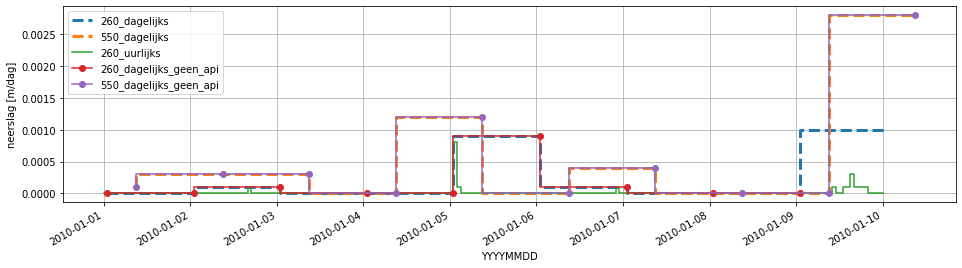

In [19]:
fig, ax = plt.subplots(figsize=(16, 4))
precip1["RH"].plot(
    ax=ax,
    drawstyle="steps",
    ls="--",
    lw=3,
    label=str(precip1.station) + "_dagelijks",
)

precip2["RD"].plot(
    ax=ax,
    drawstyle="steps",
    ls="--",
    lw=3,
    label=str(precip2.station) + "_dagelijks",
)

precip3["RH"].plot(
    ax=ax,
    drawstyle="steps",
    label=str(precip3.station) + "_uurlijks",
)

precip4["RH"].plot(
    ax=ax,
    drawstyle="steps",
    marker="o",
    label=str(precip4.station) + "_dagelijks_geen_api",
)

precip5["RD"].plot(
    ax=ax,
    drawstyle="steps",
    marker="o",
    label=str(precip5.station) + "_dagelijks_geen_api",
)


ax.legend()
ax.grid()
ax.set_ylabel("neerslag [m/dag]")


The locations of the stations can be plotted onto a map using the contextily package.

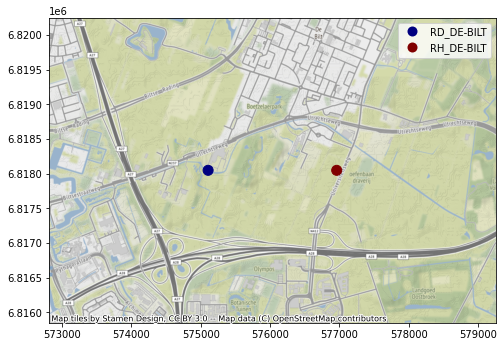

In [20]:
import contextily as cx

oc = hpd.ObsCollection([precip1, precip2])
gdf = oc.to_gdf()
gdf = gdf.set_crs(28992)
gdf = gdf.to_crs(3857)
gdf["name"] = gdf.index
ax = gdf.buffer(2000).plot(alpha=0, figsize=(8, 8))
gdf.plot("name", ax=ax, cmap="jet", legend=True, markersize=100)
cx.add_basemap(ax)


## [Evaporation](#top)<a id=EvapRef></a>

KNMI provides the Makking reference evaporation (meteo_var EV24). Hydropandas provides a posssibility to calculate three different types of reference evaporation from data of KNMI meteo stations:
- Penman
- Hargreaves
- Makkink (in the same way as KNMI)

These three types of reference evaporation are calculated the same way as described by [Allen et al. 1990](https://www.fao.org/3/x0490E/x0490e07.htm#solar%20radiation) and [STOWA rapport](https://edepot.wur.nl/163482). Be aware that the last report is written in Dutch and contains errors in the units.

The following variables from the KNMI are used for each reference evaporation type:
- Penman: average (TG), minimum (TN) and maximum (TX) temperature, de global radiation (Q), de windspeed (FG) en de relative humidity (PG).
- Hargreaves: average (TG), minimum (TN) and maximum (TX) temperature
- Makkink: average temperature (TG) and global radiation (Q)

### Comparison Makkink

Lets compare Hypdropandas Makkink verdamping evaporation with the EV24 Makkink verdamping of the KNMI. When Hydropandas Makkink evaporation is rounded (on 4 decimals), the estimate is the same as for the KNMI estimate.

In [21]:
ev24 = hpd.EvaporationObs.from_knmi(
    stn=260, start="2022-1-1"
)  # et_type='EV24' by default
makk = hpd.EvaporationObs.from_knmi(meteo_var="makkink", stn=260, start="2022-1-1")


INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable EV24from 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi EV24 data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable makkinkfrom 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi TG data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi Q data from station 260-DE-BILT between 2022-01-01 00:00:00 and None


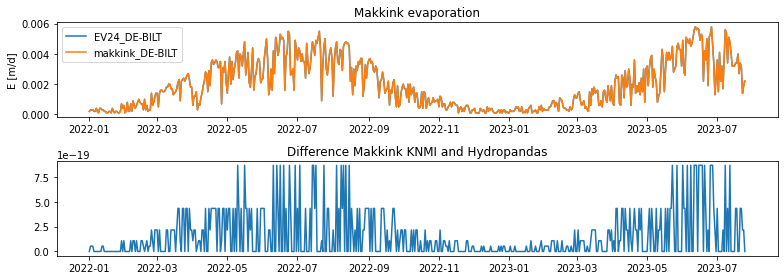

In [22]:
f, ax = plt.subplots(2, figsize=(11, 4))
ax[0].plot(ev24, label=ev24.name)
ax[0].plot(makk.round(4), label=makk.name)
ax[0].set_ylabel("E [m/d]")
ax[0].set_title("Makkink evaporation")
ax[0].legend()
ax[1].plot(ev24["EV24"] - makk["makkink"].round(4))
ax[1].set_title("Difference Makkink KNMI and Hydropandas")
f.tight_layout()


### Comparison Penman, Makkink en Hargreaves
On average Penman gives a higher estimate for reference evaporation than Makkink (~0.55mm). This can be explained by the fact that Penman takes into account windspeed and Makkink ignores this proces. Hargreaves is a very simple way of estimation the evaporation, only taking into account temperature and extraterrestial radiation. Therefore it gives a lower estimate for the reference evporatoin compared to the two other methods (~-0.35mm wrt Makkink).

In [23]:
penm = hpd.EvaporationObs.from_knmi(
    meteo_var="penman", stn=260, start="2022-1-1"
).squeeze()
harg = hpd.EvaporationObs.from_knmi(
    meteo_var="hargreaves", stn=260, start="2022-1-1"
).squeeze()


INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable penmanfrom 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi TG data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi TN data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi TX data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi Q data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi FG data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:download knmi UG data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable hargreavesfrom 2022-01-01 00:00:00 to None
INFO:hydropandas.io.knmi:download knmi TG data from station 260-DE-BILT between 2022-01-01 00:00:00 and None
INFO:h

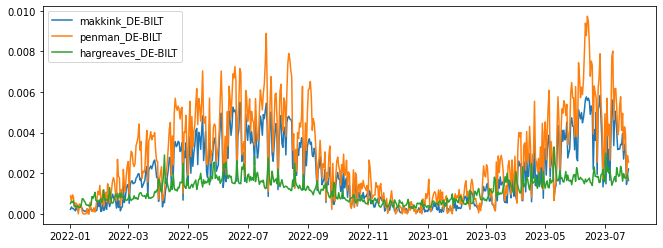

In [24]:
f, ax = plt.subplots(figsize=(11, 4))
ax.plot(makk, label=makk.name)
ax.plot(penm, label=penm.name)
ax.plot(harg, label=harg.name)
ax.legend()


## [Spatial interpolate (Makkink) Evaporation?](#top)<a id=EvapInterp></a>

Does interpolation matter? There are ways to interpolate evaporation datasets. However currently the nearest station is always used in HydroPandas' methods. Does this give different results? First lets look spatially.

Get all stations where EV24 is measured

In [25]:
stns = knmi.get_stations(meteo_var="EV24").sort_index()


Collect all EV24 data ever measured by KNMI

In [26]:
tmin = "1950-01-01"
tmax = "2022-04-11"

# empty dataframe
df = pd.DataFrame(
    columns=stns.index
)  # index=pd.date_range(start=tmin, end=tmax, freq='H')

for stn in tqdm(stns.index):
    df_stn = hpd.MeteoObs.from_knmi(
        meteo_var="EV24", stn=stn, fill_missing_obs=False, start=tmin, end=tmax
    )
    df[stn] = df_stn

df


  0%|          | 0/36 [00:00<?, ?it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 210 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 210-VALKENBURG between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


  3%|▎         | 1/36 [00:00<00:22,  1.57it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 215 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 215-VOORSCHOTEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


  6%|▌         | 2/36 [00:00<00:14,  2.34it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 235 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 235-DE-KOOY between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


  8%|▊         | 3/36 [00:01<00:19,  1.70it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 240 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 240-SCHIPHOL between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 11%|█         | 4/36 [00:02<00:20,  1.55it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 242 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 242-VLIELAND between 1950-01-01 00:00:00 and 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:no measurements found for station 242-VLIELAND between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 14%|█▍        | 5/36 [00:02<00:18,  1.72it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 249 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 249-BERKHOUT between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 17%|█▋        | 6/36 [00:03<00:17,  1.73it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 251 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 251-HOORN-TERSCHELLING between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 19%|█▉        | 7/36 [00:03<00:15,  1.82it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 257 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 257-WIJK-AAN-ZEE between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 22%|██▏       | 8/36 [00:04<00:15,  1.76it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 260 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 260-DE-BILT between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 25%|██▌       | 9/36 [00:05<00:17,  1.54it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 265 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 265-SOESTERBERG between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 28%|██▊       | 10/36 [00:06<00:17,  1.53it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 267 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 267-STAVOREN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 31%|███       | 11/36 [00:06<00:14,  1.67it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 269 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 269-LELYSTAD between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 33%|███▎      | 12/36 [00:07<00:13,  1.79it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 270 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 270-LEEUWARDEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 36%|███▌      | 13/36 [00:07<00:13,  1.68it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 273 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 273-MARKNESSE between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 39%|███▉      | 14/36 [00:08<00:11,  1.87it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 275 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 275-DEELEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 42%|████▏     | 15/36 [00:08<00:12,  1.71it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 277 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 277-LAUWERSOOG between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 44%|████▍     | 16/36 [00:09<00:10,  1.90it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 278 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 278-HEINO between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 47%|████▋     | 17/36 [00:09<00:09,  1.98it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 279 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 279-HOOGEVEEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 50%|█████     | 18/36 [00:10<00:09,  1.96it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 280 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 280-EELDE between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 53%|█████▎    | 19/36 [00:10<00:10,  1.69it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 283 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 283-HUPSEL between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 56%|█████▌    | 20/36 [00:11<00:08,  1.79it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 286 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 286-NIEUW-BEERTA between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 58%|█████▊    | 21/36 [00:11<00:07,  1.97it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 290 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 290-TWENTHE between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 61%|██████    | 22/36 [00:12<00:08,  1.74it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 310 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 310-VLISSINGEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 64%|██████▍   | 23/36 [00:13<00:08,  1.61it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 319 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 319-WESTDORPE between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 67%|██████▋   | 24/36 [00:13<00:06,  1.72it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 323 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 323-WILHELMINADORP between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 69%|██████▉   | 25/36 [00:14<00:05,  1.84it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 330 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 72%|███████▏  | 26/36 [00:14<00:05,  1.81it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 340 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 340-WOENSDRECHT between 1950-01-01 00:00:00 and 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:no measurements found for station 340-WOENSDRECHT between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 75%|███████▌  | 27/36 [00:15<00:04,  1.89it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 344 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 344-ROTTERDAM between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 78%|███████▊  | 28/36 [00:16<00:05,  1.58it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 348 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 348-CABAUW between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 81%|████████  | 29/36 [00:16<00:04,  1.56it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 350 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 350-GILZE-RIJEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 83%|████████▎ | 30/36 [00:17<00:04,  1.48it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 356 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 356-HERWIJNEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 86%|████████▌ | 31/36 [00:17<00:03,  1.64it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 370 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 370-EINDHOVEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 89%|████████▉ | 32/36 [00:18<00:02,  1.54it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 375 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 375-VOLKEL between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 92%|█████████▏| 33/36 [00:19<00:01,  1.51it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 377 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 377-ELL between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 94%|█████████▍| 34/36 [00:19<00:01,  1.72it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 380 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 380-MAASTRICHT between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


 97%|█████████▋| 35/36 [00:20<00:00,  1.53it/s]

INFO:hydropandas.io.knmi:get KNMI data from station 391 and meteo variable EV24from 1950-01-01 00:00:00 to 2022-04-11 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 391-ARCEN between 1950-01-01 00:00:00 and 2022-04-11 00:00:00


100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


,210,215,235,240,242,249,251,257,260,265,...,340,344,348,350,356,370,375,377,380,391
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
1987-03-26 01:00:00,0.0006,NaN,0.0006,NaN,NaN,NaN,NaN,NaN,0.0005,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0008,NaN,NaN,0.0010,NaN
1987-03-27 01:00:00,0.0016,NaN,0.0015,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0016,NaN,NaN,0.0017,NaN,NaN,0.0024,NaN
1987-03-28 01:00:00,0.0008,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0007,NaN,...,NaN,NaN,0.0007,NaN,NaN,0.0005,NaN,NaN,0.0008,NaN
1987-03-29 01:00:00,0.0013,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0010,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,0.0014,NaN
1987-03-30 01:00:00,0.0019,NaN,0.0021,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0017,NaN,NaN,0.0015,NaN,NaN,0.0018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-29 01:00:00,0.0023,0.0022,0.0020,0.0020,NaN,0.0015,0.0018,0.0014,0.0022,NaN,...,NaN,0.0026,0.0023,0.0018,0.0022,0.0024,0.0019,0.0025,0.0025,0.0023
2016-04-30 01:00:00,0.0023,0.0021,0.0025,0.0020,NaN,0.0022,0.0027,0.0022,0.0014,NaN,...,NaN,0.0021,0.0016,0.0014,0.0012,0.0015,0.0014,0.0010,0.0010,0.0009
2016-05-01 01:00:00,0.0023,0.0022,0.0029,0.0022,NaN,0.0021,0.0028,0.0026,0.0023,NaN,...,NaN,0.0025,0.0022,0.0021,0.0021,0.0022,0.0021,0.0009,0.0011,0.0015


According to the KNMI, thin plate spline is the best way to interpolate Makkink evaporation. Thats also how they provide the gridded Makkink evaporation : 

- [Evaporation Dataset - gridded daily Makkink evaporation for the Netherlands](https://dataplatform.knmi.nl/dataset/ev24-2)
- [Interpolation of Makkink evaporation in the
Netherlands - Paul Hiemstra and Raymond Sluiter (2011)](https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR327.pdf)

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


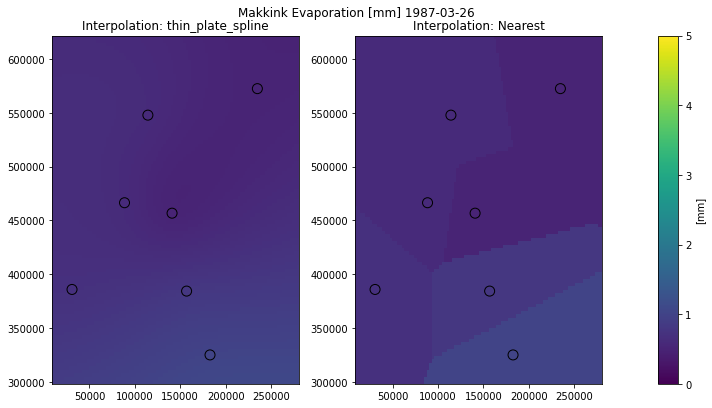

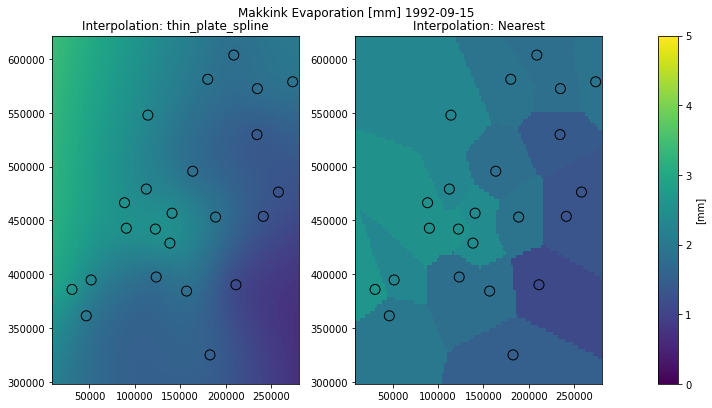

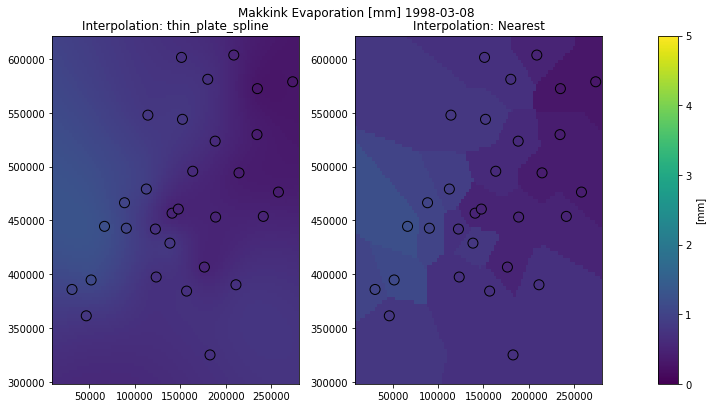

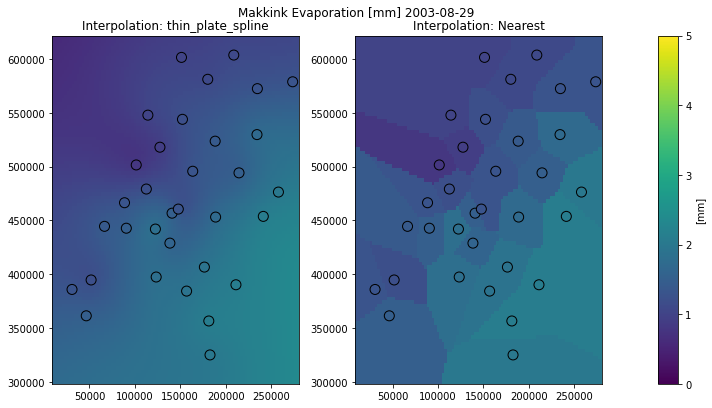

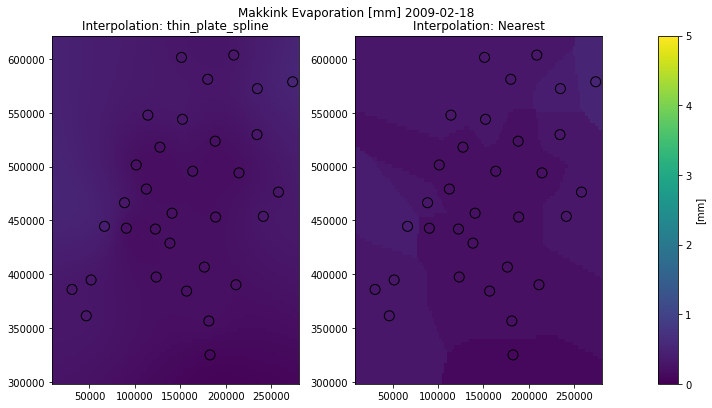

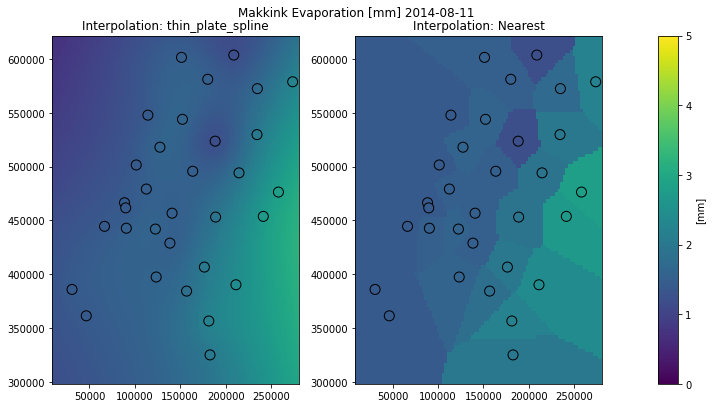

In [27]:
xy = stns.loc[df.columns, ["x", "y"]]

for idx in tqdm(df.index[0 : len(df) : 2000]):
    # get all stations with values for this date
    val = df.loc[idx].dropna() * 1000  # mm
    # get stations for this date
    coor = xy.loc[val.index].to_numpy()
    if (
        len(val) < 3
    ):  # if there are less than 3 stations, thin plate spline does not work
        # options: linear, multiquadric, gaussian,
        kernel = "linear"

    else:
        kernel = "thin_plate_spline"
        # options:
        # 'inverse_quadratic', 'linear', 'multiquadric', 'gaussian',
        # 'inverse_multiquadric', 'cubic', 'quintic', 'thin_plate_spline'

    # create an scipy interpolator
    rbf = RBFInterpolator(coor, val.to_numpy(), epsilon=1, kernel=kernel)

    nea = NearestNDInterpolator(coor, val.to_numpy())

    # interpolate on grid of the Netherlands
    grid = np.mgrid[10000:280000:100j, 300000:620000:100j]
    grid2 = grid.reshape(2, -1).T  # interpolator only takes array [[x0, y0],
    #  [x1, y1]]
    val_rbf = rbf.__call__(grid2).reshape(100, 100)
    val_nea = nea.__call__(grid2).reshape(100, 100)

    # create figure
    fig, ax = plt.subplot_mosaic("AAAABBBBC", figsize=(10, 5.925))
    fig.suptitle(f"Makkink Evaporation [mm] {idx.date()}", y=0.95)
    vmin = 0
    vmax = 5

    ax["A"].set_title(f"Interpolation: {kernel}")
    ax["A"].pcolormesh(*grid, val_rbf, vmin=vmin, vmax=vmax)
    ax["B"].set_title(f"Interpolation: Nearest")
    ax["B"].pcolormesh(*grid, val_nea, vmin=vmin, vmax=vmax)
    ax["A"].scatter(*coor.T, c=val, s=100, ec="k", vmin=vmin, vmax=vmax)
    p = ax["B"].scatter(*coor.T, c=val, s=100, ec="k", vmin=vmin, vmax=vmax)
    cb = fig.colorbar(p, cax=ax["C"])
    cb.set_label("[mm]")
    fig.tight_layout()


The same method is implemented in Hydropandas for an ObsCollection.

In [28]:
sd = "2022-01-01"
ed = "2022-12-31"
oc = hpd.read_knmi(stns=stns.index, starts=sd, ends=ed, meteo_vars=["EV24"])
oc_et = oc.interpolate(xy=[(100000, 330000)])
eti = oc_et.iloc[0].obs
eti


INFO:hydropandas.io.knmi:get KNMI data from station 210 and meteo variable EV24from 2022-01-01 00:00:00 to 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 210-VALKENBURG between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:no measurements found for station 210-VALKENBURG between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:get KNMI data from station 215 and meteo variable EV24from 2022-01-01 00:00:00 to 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 215-VOORSCHOTEN between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:get KNMI data from station 235 and meteo variable EV24from 2022-01-01 00:00:00 to 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:download knmi EV24 data from station 235-DE-KOOY between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:get KNMI data from station 240 and meteo variable EV24from 2022-01-01 00:00:00 to 2

,100000_330000
YYYYMMDD,
2022-01-01 01:00:00,0.000257
2022-01-02 01:00:00,0.000573
2022-01-03 01:00:00,0.000325
2022-01-04 01:00:00,0.000140
2022-01-05 01:00:00,0.000156
...,...
2022-12-27 01:00:00,0.000145
2022-12-28 01:00:00,0.000257
2022-12-29 01:00:00,0.000097


In [29]:
etn = hpd.MeteoObs.from_knmi(
    xy=(100000, 330000), start=sd, end=ed, meteo_var="EV24", fill_missing_obs=True
)
etn


INFO:hydropandas.io.knmi:get KNMI data from station nearest to coordinates (100000, 330000) and meteovariable EV24
INFO:hydropandas.io.knmi:download knmi EV24 data from station 340-WOENSDRECHT between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:no measurements found for station 340-WOENSDRECHT between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:station 340 has no measurements between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:trying to get measurements from nearest station
INFO:hydropandas.io.knmi:download knmi EV24 data from station 323-WILHELMINADORP between 2022-01-01 00:00:00 and 2022-12-31 00:00:00
INFO:hydropandas.io.knmi:station 323 has 4 missing measurements
INFO:hydropandas.io.knmi:trying to fill 4 measurements with station [310]
INFO:hydropandas.io.knmi:download knmi EV24 data from station 310-VLISSINGEN between 2022-01-01 00:00:00 and 2022-12-31 00:00:00


,EV24,station
2022-01-01 01:00:00,0.0003,323
2022-01-02 01:00:00,0.0004,323
2022-01-03 01:00:00,0.0003,323
2022-01-04 01:00:00,0.0002,323
2022-01-05 01:00:00,0.0002,323
...,...,...
2022-12-27 01:00:00,0.0004,323
2022-12-28 01:00:00,0.0003,323
2022-12-29 01:00:00,0.0001,323
2022-12-30 01:00:00,0.0002,323


As can be seen, for one location the interpolation method is significantly slower. Lets see how the values compare for a time series.

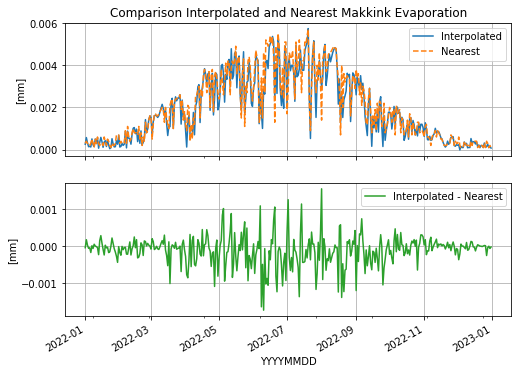

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
eti.plot(ax=ax[0])
etn.plot(ax=ax[0], linestyle="--", color="C1")
ax[0].set_title("Comparison Interpolated and Nearest Makkink Evaporation")
ax[0].set_ylabel("[mm]")
ax[0].grid()
ax[0].legend(["Interpolated", "Nearest"])

(eti.squeeze() - etn["EV24"].squeeze()).plot(ax=ax[1], color="C2")
ax[1].set_ylabel("[mm]")
ax[1].grid()
ax[1].legend(["Interpolated - Nearest"])


The interpolated evaporation can also be collected for multiple points (using x and y in a list of DataFrame) in an ObsCollection

In [31]:
oc_et = oc.interpolate(xy=[(100000, 320000), (100000, 330000), (100000, 340000)])
oc_et


,x,y,filename,source,unit,station,meteo_var,obs
name,,,,,,,,
100000_320000,100000,320000,,interpolation,,NaN,EV24,EvaporationObs 100000_320000 -----metadata----...
100000_330000,100000,330000,,interpolation,,NaN,EV24,EvaporationObs 100000_330000 -----metadata----...
100000_340000,100000,340000,,interpolation,,NaN,EV24,EvaporationObs 100000_340000 -----metadata----...


The interpolation method is slow at first, but if collected for many different locations the time penalty is not that significant anymore. 